In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import shap

c:\Users\Caitlyn\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed=123):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything()

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def bootstrap_auc(y_true, y_score, iters):
    orig_auc = roc_auc_score(y_true, y_score)
    y_true0_ind = list(np.where(y_true == 0)[0])
    y_true1_ind = list(np.where(y_true == 1)[0])
    samp_size = len(y_score)
    estimated_auc = []
    for i in range(iters):
        if samp_size < 100:
            samp_indices = random.choices(y_true0_ind, k = len(y_true0_ind))
            samp_indices.extend(random.choices(y_true1_ind, k = len(y_true1_ind)))
        else:
            samp_indices = random.choices(range(0, samp_size), k = samp_size)
        samp_score = [y_score[i] for i in samp_indices]
        samp_true = [y_true[i] for i in samp_indices]
        estimated_auc.append(roc_auc_score(samp_true, samp_score) - orig_auc)
    lower = np.percentile(estimated_auc, 2.5)
    upper = np.percentile(estimated_auc, 97.5)
    return (orig_auc + lower, orig_auc + upper)

In [5]:
def bootstrap_pr(y_true, y_score, iters):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    orig_auc = auc(recall, precision)
    y_true0_ind = list(np.where(y_true == 0)[0])
    y_true1_ind = list(np.where(y_true == 1)[0])
    samp_size = len(y_score)
    estimated_auc = []
    for i in range(iters):
        if samp_size < 100:
            samp_indices = random.choices(y_true0_ind, k = len(y_true0_ind))
            samp_indices.extend(random.choices(y_true1_ind, k = len(y_true1_ind)))
        else:
            samp_indices = random.choices(range(0, samp_size), k = samp_size)
        samp_score = [y_score[i] for i in samp_indices]
        samp_true = [y_true[i] for i in samp_indices]
        precision, recall, thresholds = precision_recall_curve(samp_true, samp_score)
        auc_precision_recall = auc(recall, precision)
        estimated_auc.append(auc_precision_recall - orig_auc)
    lower = np.percentile(estimated_auc, 2.5)
    upper = np.percentile(estimated_auc, 97.5)
    return (orig_auc + lower, orig_auc + upper)

In [6]:
X, y = make_multilabel_classification(n_samples = 1000, n_features = 30, n_classes = 2, n_labels = 2, random_state = 1)
X = pd.DataFrame(X)
y = pd.DataFrame(y, columns = ['Output1', 'Output2'])
print(X.shape, y.shape)

(1000, 30) (1000, 2)


In [7]:
X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,3.0,5.0,2.0,1.0
1,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0
2,1.0,0.0,0.0,4.0,3.0,4.0,3.0,3.0,1.0,1.0,...,4.0,4.0,1.0,0.0,1.0,0.0,1.0,3.0,2.0,0.0


In [8]:
y.head(3)

,Output1,Output2
0,1,1
1,0,0
2,1,1


In [9]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size = 0.20, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.50, random_state = 1)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(800, 30) (800, 2)
(100, 30) (100, 2)
(100, 30) (100, 2)


In [10]:
print(y.iloc[:,0].value_counts())
print(y.iloc[:,1].value_counts())

1    572
0    428
Name: Output1, dtype: int64
1    641
0    359
Name: Output2, dtype: int64


In [11]:
class Tutorial_DS(Dataset):
    def __init__(self, X, y):
        self.x = X.copy()
        self.labels = y.copy()
    
    # Shape function
    def shape(self):
        return self.x.shape, self.labels.shape

    # Length function, needed for DataLoader
    def __len__(self):
        return len(self.labels.iloc[:,0])
    
    # Return function
    def __getitem__(self, idx):
        return self.x.iloc[idx].values.astype(np.float32), self.labels.iloc[idx].values.astype(np.float32)

In [12]:
train_ds = Tutorial_DS(X_train, y_train)
val_ds = Tutorial_DS(X_val, y_val)
test_ds = Tutorial_DS(X_test, y_test)
print(train_ds.shape())
print(val_ds.shape())
print(test_ds.shape())

((800, 30), (800, 2))
((100, 30), (100, 2))
((100, 30), (100, 2))


In [13]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

In [14]:
class MLC(nn.Module):
    def __init__(self, input_dim, hidden_units, n_labels1, n_labels2):
        # Inherit from torch.nn.Module
        super(MLC, self).__init__()
        # Assign parameters to model attributes
        self.input_dim = input_dim
        self.n_units = hidden_units
        self.output1_labels = n_labels1
        self.output2_labels = n_labels2

        # Define network layers
        ## First fully-connected layer
        self.fc1 = nn.Linear(in_features = self.input_dim, out_features = self.n_units) # input: input_dim, output: hidden_units
        ## ReLU activation function
        self.relu = nn.ReLU()
        ## Output fully-connected layers
        self.fc_output1 = nn.Linear(in_features = self.n_units, out_features = self.output1_labels) # input: hidden_units, output: n_labels1
        self.fc_output2 = nn.Linear(in_features = self.n_units, out_features = self.output2_labels) # input: hidden_units, output: n_labels2

        # Forward pass method
    def forward(self, X):
        X = self.fc1(X)
        X = self.relu(X)
        logits_1 = self.fc_output1(X)
        logits_2 = self.fc_output2(X)
        return logits_1, logits_2

In [15]:
# Define model parameters
input_dim = X_train.shape[1]
hidden_units = int(2/3*input_dim)
n_labels1 = np.unique(y_train['Output1'].values.ravel()).max()
n_labels2 = np.unique(y_train['Output2'].values.ravel()).max()
print(input_dim, hidden_units, n_labels1, n_labels2)

30 20 1 1


In [16]:
# Instantiate model
model = MLC(input_dim = input_dim, hidden_units = hidden_units, n_labels1 = n_labels1, n_labels2 = n_labels2)

# Number of epochs
n_epochs = 200

# Loss functions
loss_func1 = torch.nn.BCEWithLogitsLoss()
loss_func2 = torch.nn.BCEWithLogitsLoss()

# Optimizer and learning rate
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Early stopping
min_delta = 0.001
patience = 10

print(model)

MLC(
  (fc1): Linear(in_features=30, out_features=20, bias=True)
  (relu): ReLU()
  (fc_output1): Linear(in_features=20, out_features=1, bias=True)
  (fc_output2): Linear(in_features=20, out_features=1, bias=True)
)


In [17]:
# Initialize zeroed count and vectors
early_stopping_count = 0
auc_train_scores = []
auc_val_scores = []
loss_train_scores = []
loss_val_scores = []

# Start time
time_start = time.time()

print('\nTraining model...\n')

for epoch in range(n_epochs):
    # Initialize batch actual values, predictions, and loss
    actual_train_output1 = []
    pred_train_output1 = []
    actual_train_output2 = []
    pred_train_output2 = []

    actual_val_output1 = []
    pred_val_output1 = []
    actual_val_output2 = []
    pred_val_output2 = []

    train_loss1_sum = 0
    train_loss2_sum = 0

    val_loss1_sum = 0
    val_loss2_sum = 0

    # Place model in training model
    model.train()

    # Iterate through training data batches
    for x, y in train_dl:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        pred_y1, pred_y2 = model(x)

        # Sum losses
        loss1 = loss_func1(pred_y1[:, 0], y[:, 0])
        loss2 = loss_func2(pred_y2[:, 0], y[:, 1])
        loss = loss1 + loss2

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update vectors with real values and predictions
        actual_train_output1.extend(pd.DataFrame(y.detach().numpy())[0].to_numpy())
        pred_train_output1.extend(sigmoid(pred_y1[:, 0].detach().numpy()))

        actual_train_output2.extend(pd.DataFrame(y.detach().numpy())[1].to_numpy())
        pred_train_output2.extend(sigmoid(pred_y2[:, 0].detach().numpy()))

        # Update individual loss for display
        train_loss1_sum += loss1
        train_loss2_sum += loss2
    
    # Calculate epoch training loss and AUC
    train_loss_final = train_loss1_sum + train_loss2_sum
    train_auc1 = roc_auc_score(actual_train_output1, pred_train_output1)
    train_auc2 = roc_auc_score(actual_train_output2, pred_train_output2)

    # Add final training loss and AUC to vectors
    loss_train_scores.append([train_loss_final.detach().numpy(), train_loss1_sum.detach().numpy(), train_loss2_sum.detach().numpy()])
    auc_train_scores.append([train_auc1, train_auc2])

    # Put model into evaluation mode for validation
    model.eval()

    # Iterate through validation data batches
    for x, y in val_dl:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        pred_y1, pred_y2 = model(x)

        # Sum losses
        loss1 = loss_func1(pred_y1[:, 0], y[:, 0])
        loss2 = loss_func2(pred_y2[:, 0], y[:, 1])
        loss = loss1 + loss2

        # Update vectors with real values and predictions
        actual_val_output1.extend(pd.DataFrame(y.detach().numpy())[0].to_numpy())
        pred_val_output1.extend(sigmoid(pred_y1[:, 0].detach().numpy()))

        actual_val_output2.extend(pd.DataFrame(y.detach().numpy())[1].to_numpy())
        pred_val_output2.extend(sigmoid(pred_y2[:, 0].detach().numpy()))

        # Update individual loss for display
        val_loss1_sum += loss1
        val_loss2_sum += loss2

    # Calculate epoch validation loss and AUC
    val_loss_final = val_loss1_sum + val_loss2_sum
    val_auc1 = roc_auc_score(actual_val_output1, pred_val_output1)
    val_auc2 = roc_auc_score(actual_val_output2, pred_val_output2)

    # Add final validation loss and AUC to vectors
    loss_val_scores.append([val_loss_final.detach().numpy(), val_loss1_sum.detach().numpy(), val_loss2_sum.detach().numpy()])
    auc_val_scores.append([val_auc1, val_auc2])

    # Display epoch progress
    prog_disp_freq = 1
    if (((epoch + 1) % prog_disp_freq) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print("EPOCH: %s | TRAIN. (Output1 AUC: %5.3f  Output2 AUC: %5.3f   Loss: %5.3f) | VAL. (Output1 AUC: %5.3f  Output2 AUC: %5.3f   Loss: %5.3f)" % \
            (epoch, train_auc1, train_auc2, train_loss_final, val_auc1, val_auc2, val_loss_final))

    # Early stopping
    if epoch == 0:
        best_loss = loss_val_scores[0][0]
    else:
        if loss_val_scores[epoch][0] >= (best_loss - min_delta):
            early_stopping_count += 1
        else:
            best_loss = loss_val_scores[epoch][0]
            early_stopping_count = 0
    
    if early_stopping_count == patience:
        break

time_end = time.time()

print('\nModel training complete.\n')
print('Time to train model: %.1f s\n' % (time_end - time_start))


Training model...

EPOCH: 0 | TRAIN. (Output1 AUC: 0.796  Output2 AUC: 0.715   Loss: 16.061) | VAL. (Output1 AUC: 0.878  Output2 AUC: 0.668   Loss: 2.313)
EPOCH: 1 | TRAIN. (Output1 AUC: 0.897  Output2 AUC: 0.766   Loss: 14.600) | VAL. (Output1 AUC: 0.915  Output2 AUC: 0.714   Loss: 2.162)
EPOCH: 2 | TRAIN. (Output1 AUC: 0.933  Output2 AUC: 0.806   Loss: 13.395) | VAL. (Output1 AUC: 0.934  Output2 AUC: 0.764   Loss: 2.006)
EPOCH: 3 | TRAIN. (Output1 AUC: 0.955  Output2 AUC: 0.848   Loss: 12.140) | VAL. (Output1 AUC: 0.947  Output2 AUC: 0.803   Loss: 1.807)
EPOCH: 4 | TRAIN. (Output1 AUC: 0.965  Output2 AUC: 0.882   Loss: 10.843) | VAL. (Output1 AUC: 0.955  Output2 AUC: 0.839   Loss: 1.675)
EPOCH: 5 | TRAIN. (Output1 AUC: 0.973  Output2 AUC: 0.915   Loss: 9.877) | VAL. (Output1 AUC: 0.966  Output2 AUC: 0.882   Loss: 1.524)
EPOCH: 6 | TRAIN. (Output1 AUC: 0.978  Output2 AUC: 0.937   Loss: 8.876) | VAL. (Output1 AUC: 0.973  Output2 AUC: 0.904   Loss: 1.358)
EPOCH: 7 | TRAIN. (Output1 AUC

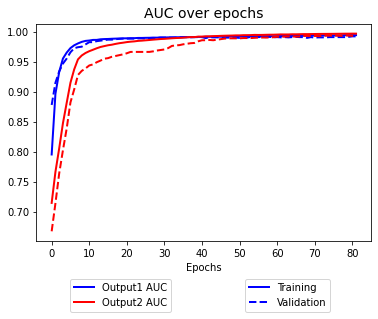

In [18]:
# AUC Plot
auc_train_scores = pd.DataFrame(auc_train_scores)
auc_val_scores = pd.DataFrame(auc_val_scores)

plot_lines = []
l1, = plt.plot(auc_train_scores[0], color = 'blue', linewidth = 2, linestyle = '-')
l2, = plt.plot(auc_val_scores[0], color = 'blue', linewidth = 2, linestyle = '--')
l3, = plt.plot(auc_train_scores[1], color = 'red', linewidth = 2, linestyle = '-')
l4, = plt.plot(auc_val_scores[1], color = 'red', linewidth = 2, linestyle = '--')

plot_lines.append([l1, l2, l3, l4])

legend1 = plt.legend(plot_lines[0], ["Training", "Validation"], loc = "upper center", bbox_to_anchor = (0.75, -0.15), fancybox = True)
plt.legend([plot_lines[0][0], plot_lines[0][2]], ["Output1 AUC", "Output2 AUC"], loc = "upper center", bbox_to_anchor = (0.25, -0.15), fancybox = True)
plt.gca().add_artist(legend1)
plt.title("AUC over epochs", fontsize = 14)
plt.xlabel("Epochs")
plt.show()

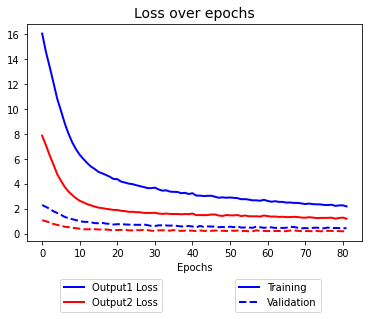

In [19]:
# Loss Plot
loss_train_scores = pd.DataFrame(loss_train_scores)
loss_val_scores = pd.DataFrame(loss_val_scores)

plot_lines = []
l1, = plt.plot(loss_train_scores[0], color = 'blue', linewidth = 2, linestyle = '-')
l2, = plt.plot(loss_val_scores[0], color = 'blue', linewidth = 2, linestyle = '--')
l3, = plt.plot(loss_train_scores[1], color = 'red', linewidth = 2, linestyle = '-')
l4, = plt.plot(loss_val_scores[1], color = 'red', linewidth = 2, linestyle = '--')

plot_lines.append([l1, l2, l3, l4])

legend1 = plt.legend(plot_lines[0], ["Training", "Validation"], loc = "upper center", bbox_to_anchor = (0.75, -0.15), fancybox = True)
plt.legend([plot_lines[0][0], plot_lines[0][2]], ["Output1 Loss", "Output2 Loss"], loc = "upper center", bbox_to_anchor = (0.25, -0.15), fancybox = True)
plt.gca().add_artist(legend1)
plt.title("Loss over epochs", fontsize = 14)
plt.xlabel("Epochs")
plt.show()

In [20]:
# Running testing set through model

# Initialize test set vectors
actual_test_output1 = []
pred_test_output1 = []

actual_test_output2 = []
pred_test_output2 = []

# Place model in evaluation mode
model.eval()

# Zero out the gradients
optimizer.zero_grad()

# Iterate through test data batches
for x, y in test_dl:
    # Forward pass
    pred_y1, pred_y2 = model(x)

    # Update vectors with real values and predictions
    actual_test_output1.extend(pd.DataFrame(y.detach().numpy())[0].to_numpy())
    pred_test_output1.extend(sigmoid(pred_y1[:, 0].detach().numpy()))

    actual_test_output2.extend(pd.DataFrame(y.detach().numpy())[1].to_numpy())
    pred_test_output2.extend(sigmoid(pred_y2[:, 0].detach().numpy()))

In [21]:
# Calculate test AUC for Receiver-Operator Characteristic Curve
test_auc_y1 = roc_auc_score(actual_test_output1, pred_test_output1)
test_auc_y2 = roc_auc_score(actual_test_output2, pred_test_output2)
[lower1, upper1] = bootstrap_auc(np.array(actual_test_output1), pred_test_output1, 1000)
[lower2, upper2] = bootstrap_auc(np.array(actual_test_output2), pred_test_output2, 1000)
print("Testing set 95%% AUC CI for Output 1: %5.3f [%5.3f, %5.3f]" % (test_auc_y1, lower1, upper1))
print("Testing set 95%% AUC CI for Output 2: %5.3f [%5.3f, %5.3f]" % (test_auc_y2, lower2, upper2))

Testing set 95% AUC CI for Output 1: 0.986 [0.967, 0.998]
Testing set 95% AUC CI for Output 2: 0.979 [0.950, 0.997]


In [22]:
# Calculate test AUC for Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(actual_test_output1, pred_test_output1)
auc_pr1 = auc(recall, precision)
precision, recall, thresholds = precision_recall_curve(actual_test_output2, pred_test_output2)
auc_pr2 = auc(recall, precision)
[lower1, upper1] = bootstrap_pr(np.array(actual_test_output1), pred_test_output1, 1000)
[lower2, upper2] = bootstrap_pr(np.array(actual_test_output2), pred_test_output2, 1000)
print("Testing set 95%% AUPRC CI for Output 1: %5.3f [%5.3f, %5.3f]" % (auc_pr1, lower1, upper1))
print("Testing set 95%% AUPRC CI for Output 2: %5.3f [%5.3f, %5.3f]" % (auc_pr2, lower2, upper2))

Testing set 95% AUPRC CI for Output 1: 0.986 [0.965, 0.999]
Testing set 95% AUPRC CI for Output 2: 0.985 [0.965, 0.999]


In [23]:
# SHAP values for outcome 1

# Define function to wrap model to transform data to numpy
f = lambda x: model(Variable(torch.from_numpy(x)))[0].detach().numpy()

# Convert pandas dataframe to numpy
train_vals = X_train.to_numpy(dtype = np.float32)
test_vals = X_test.to_numpy(dtype = np.float32)

# SHAP explainer, requires conversion from tensor to numpy using function f
explainer = shap.KernelExplainer(f, train_vals[:100])

shap_values_y1 = explainer.shap_values(test_vals)

100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


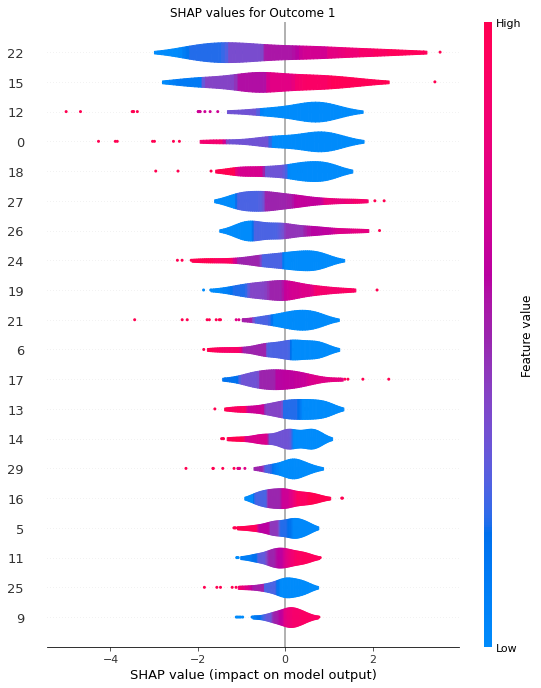

In [24]:
# Getting predictor names
feature_names = X_train.columns

# SHAP violin plot for outcome 1
shap.summary_plot(shap_values_y1[0], X_test, plot_type = "violin", feature_names = feature_names, show = False)
plt.title("SHAP values for Outcome 1")
plt.show()

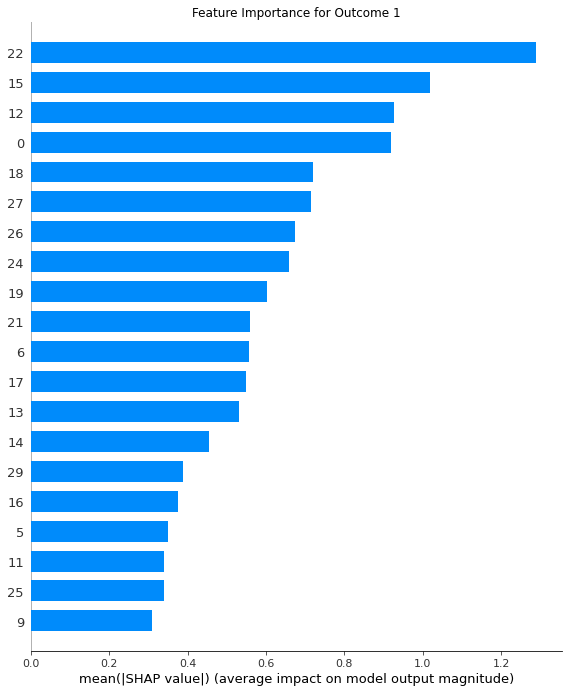

In [25]:
# SHAP barplot for outcome 1
shap.summary_plot(shap_values_y1[0], X_test, plot_type = "bar", feature_names = feature_names, show = False)
plt.title("Feature Importance for Outcome 1")
plt.show()

In [26]:
# SHAP values for outcome 2

# Define function to wrap model to transform data to numpy
f = lambda x: model(Variable(torch.from_numpy(x)))[1].detach().numpy()

# Convert pandas dataframe to numpy
train_vals = X_train.to_numpy(dtype = np.float32)
test_vals = X_test.to_numpy(dtype = np.float32)

# SHAP explainer, requires conversion from tensor to numpy using function f
explainer = shap.KernelExplainer(f, train_vals[:100])

shap_values_y2 = explainer.shap_values(test_vals)

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


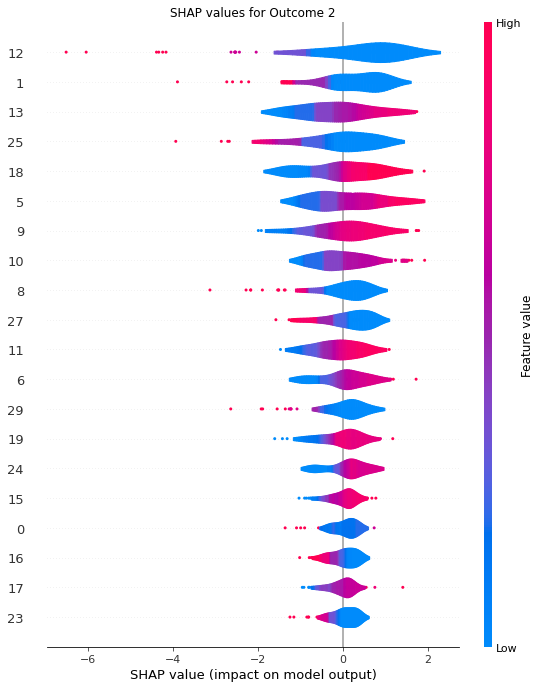

In [27]:
# SHAP violin plot for outcome 2
shap.summary_plot(shap_values_y2[0], X_test, plot_type = "violin", feature_names = feature_names, show = False)
plt.title("SHAP values for Outcome 2")
plt.show()

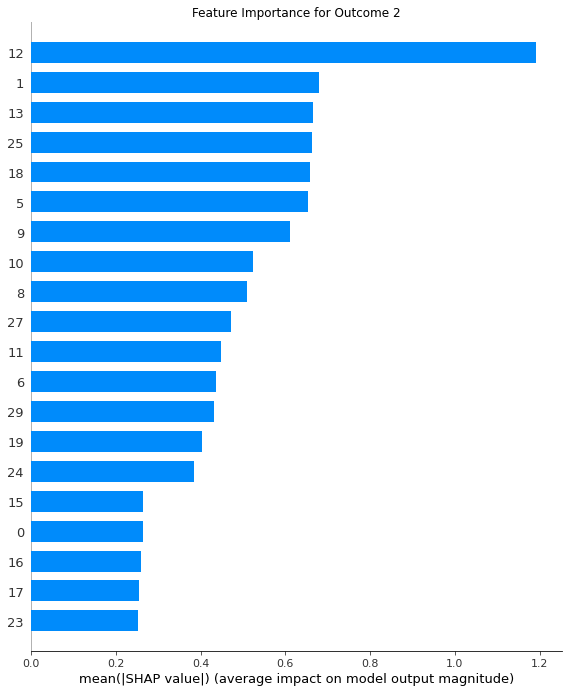

In [28]:
# SHAP barplot for outcome 2
shap.summary_plot(shap_values_y2[0], X_test, plot_type = "bar", feature_names = feature_names, show = False)
plt.title("Feature Importance for Outcome 2")
plt.show()